# WaDi A1 - Pipeline Notebook 2: Fault Injection

## Prior to this Notebook, Notebook 1 needs to be complete

* **Input:** Staged parquet from Notebook 1
* **Scope:** Injects synthetic sensor faults into normal rows in the train split, producing a three-class training dataset:
    * 0=normal
    * 1=cyber attack
    * 2=sensor fault
* **Output:** Injected parquet ready for Notebook 3 (Curate/Validate)

# Stage 0 - Setup

## 0.1 - Imports and Paths

In [1]:
from __future__ import annotations

from pathlib import Path
from datetime import datetime, timezone
import json
import random

import numpy as np
import pandas as pd
from IPython.display import display

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 180)

# Paths 
WORK_DIR     = Path("work")
PROJECT_DIR  = WORK_DIR / "wadi_A1"
DATA_DIR     = PROJECT_DIR / "data"
STAGED_DIR   = DATA_DIR / "staged"
INJECTED_DIR = DATA_DIR / "injected"
REF_DIR      = DATA_DIR / "reference"
RUN_DIR      = REF_DIR / "pipeline_runs"

for p in [INJECTED_DIR, RUN_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project:  ", PROJECT_DIR)
print("Staged:   ", STAGED_DIR)
print("Injected: ", INJECTED_DIR)

Project:   work/wadi_A1
Staged:    work/wadi_A1/data/staged
Injected:  work/wadi_A1/data/injected


## 0.2 - Helper Utilities

In [2]:
class PipelineError(RuntimeError):
    pass

def utc_now_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def write_json(path: Path, obj: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(obj, indent=2, default=str))

def read_json(path: Path) -> dict:
    return json.loads(path.read_text())

print("Helpers ready.")

Helpers ready.


## 0.3 - Configuration  
Fault injection parameters.  
All tunable constants live here.  
Seed is fixed for reproducibility. Changing it produces a different, but equally valid injection. Can be used for sensitivity analysis.

In [3]:
# 1. Dataset identity
DATASET_NAME = "WaDi.A1_9 Oct 2017"

# 2. Reproducibility
RANDOM_SEED  = 42

# 3. Fault injection parameters 
TARGET_FAULT_PCT = 0.08        # target fraction of normal rows to receive injected faults (~8%)
FAULT_DURATION_MIN  = 120      # minimum fault duration in seconds
FAULT_DURATION_MAX  = 600      # maximum fault duration in seconds
MIN_COVERAGE_RATIO  = 0.10     # sensor must have at least 10% non-null normal rows
BINARY_MAX_UNIQUE   = 5        # sensors with <= this many unique values treated as binary

# 4. Run ID 
RUN_ID = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S_utc")

# 5. Fix random seeds 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Dataset:                      {DATASET_NAME}")
print(f"Random seed:                  {RANDOM_SEED}")
print(f"Faults per sensor per split:  {TARGET_FAULT_PCT:.0%}")
print(f"Fault duration:               {FAULT_DURATION_MIN}–{FAULT_DURATION_MAX} seconds")
print(f"Min coverage ratio:           {MIN_COVERAGE_RATIO}")
print(f"Run ID:                       {RUN_ID}")

Dataset:                      WaDi.A1_9 Oct 2017
Random seed:                  42
Faults per sensor per split:  8%
Fault duration:               120–600 seconds
Min coverage ratio:           0.1
Run ID:                       20260223_175138_utc


# Stage 1 - Load Staged Data   
Load the staged parquet from Notebook 1 and the canonical `SENSOR_COLS` reference.  
All downstream stages operate on these inputs.  

## 1.1 - Load Staged Parquet

In [4]:
# Load most recent staged parquet
staged_files = sorted(STAGED_DIR.glob("wadi_staged_*.parquet"))
if not staged_files:
    raise PipelineError(f"No staged parquet found in {STAGED_DIR}")

staged_path = staged_files[-1]
print(f"Loading: {staged_path}")

df = pd.read_parquet(staged_path)
print(f"Shape:   {df.shape}")
print(f"Columns: {df.columns.tolist()[:8]} ... ({len(df.columns)} total)")
print(f"\nLabel counts:")
for label_val, label_name in [(0, "normal"), (1, "attack")]:
    n = (df["label"] == label_val).sum()
    print(f"  {label_name} ({label_val}): {n:>9,}")

print(f"\nSplit counts:")
for split in ["train", "test"]:
    n = (df["split"] == split).sum()
    print(f"  {split:<6}: {n:>9,}")

Loading: work/wadi_A1/data/staged/wadi_staged_20260223_140105_utc.parquet
Shape:   (1382402, 103)
Columns: ['timestamp', 'observation_day', 'seconds_since_start', 'split', 'label', '1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV'] ... (103 total)

Label counts:
  normal (0): 1,209,601
  attack (1):   172,801

Split counts:
  train : 1,209,601
  test  :   172,801


## 1.2 - Load SENSOR_COLS Reference

In [5]:
# Load canonical sensor column list from Notebook 1
sensor_cols_path = REF_DIR / "sensor_cols.json"
if not sensor_cols_path.exists():
    raise PipelineError(f"sensor_cols.json not found at {sensor_cols_path}")

sensor_ref  = read_json(sensor_cols_path)
SENSOR_COLS = sensor_ref["sensor_cols"]

print(f"SENSOR_COLS loaded: {len(SENSOR_COLS)} columns")
print(f"Source run ID:      {sensor_ref['run_id']}")

# Verify all SENSOR_COLS are present in the staged data
missing = [c for c in SENSOR_COLS if c not in df.columns]
if missing:
    raise PipelineError(f"SENSOR_COLS missing from staged data: {missing}")

print("All SENSOR_COLS present in staged data.")

SENSOR_COLS loaded: 98 columns
Source run ID:      20260223_140105_utc
All SENSOR_COLS present in staged data.


# Stage 2 - Identify Eligible Sensors  
Determine which sensors are candidates for fault injection.  
Binary and status columns are excluded. 
Injecting drift or bias into a column that only takes values {0, 1, 2} produces physically implausible results.  
Sensors with insufficient normal-operation data coverage are also excluded.

## 2.1 - Identify Eligible Sensors

In [6]:
# Work from normal rows only — faults are injected into normal operation
df_normal = df[df["label"] == 0].copy()

print(f"Normal rows available for injection: {len(df_normal):,}")
print(f"\nNormal rows by split:")
for split in ["train", "test"]:
    n = (df_normal["split"] == split).sum()
    print(f"  {split:<6}: {n:>9,}")

# Identify eligible sensors 
eligible   = []
ineligible = []

for col in SENSOR_COLS:
    series = df_normal[col].dropna()

    # Exclude binary/status columns
    n_unique = series.nunique()
    if n_unique <= BINARY_MAX_UNIQUE:
        ineligible.append((col, f"binary/status (unique={n_unique})"))
        continue

    # Exclude sensors with insufficient coverage
    coverage = len(series) / len(df_normal)
    if coverage < MIN_COVERAGE_RATIO:
        ineligible.append((col, f"low coverage ({coverage:.1%})"))
        continue

    eligible.append(col)

print(f"\nEligible sensors:   {len(eligible)}")
print(f"Ineligible sensors: {len(ineligible)}")
print(f"\nIneligible breakdown:")
for col, reason in ineligible:
    print(f"  {col:<35s}  {reason}")

Normal rows available for injection: 1,209,601

Normal rows by split:
  train : 1,209,601
  test  :         0

Eligible sensors:   67
Ineligible sensors: 31

Ineligible breakdown:
  1_MV_001_STATUS                      binary/status (unique=3)
  1_MV_002_STATUS                      binary/status (unique=1)
  1_MV_003_STATUS                      binary/status (unique=1)
  1_MV_004_STATUS                      binary/status (unique=3)
  1_P_001_STATUS                       binary/status (unique=2)
  1_P_003_STATUS                       binary/status (unique=2)
  1_P_005_STATUS                       binary/status (unique=2)
  1_P_006_STATUS                       binary/status (unique=1)
  2_LS_101_AH                          binary/status (unique=2)
  2_LS_101_AL                          binary/status (unique=2)
  2_LS_201_AH                          binary/status (unique=2)
  2_LS_201_AL                          binary/status (unique=2)
  2_LS_301_AH                          binary/status

# Stage 3 - Define Fault Types  
Defines five fault types based on industrial sensor failure literature.  
Each fault type has physically grounded parameter ranges derived from real-world sensor behavior in water distribution systems.  

<table style="text-align:left">
    <tr>
        <th>Fault Type</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>drift</td>
        <td>Gradual linear deviation from true value</td>
    </tr>
    <tr>
        <td>bias</td>
        <td>Sudden fixed offset added to readings</td>
    </tr>
    <tr>
        <td>precision_degradation</td>
        <td>Increased noise/variance around true value</td>
    </tr>
    <tr>
        <td>stuck_at</td>
        <td>Sensor freezes at a fixed value</td>
    </tr>
    <tr>
        <td>intermittent_dropout</td>
        <td>Random NaN dropouts simulating signal loss</td>
    </tr>
</table>

## 3.1 - Define Fault Types


In [7]:
# Fault type definitions with parameter ranges 
FAULT_TYPES = {
    "drift": {
        "description": "Gradual linear deviation from true value",
        "rate_pct_per_min": (0.5, 3.0),   # drift rate as % of sensor std per minute
    },
    "bias": {
        "description": "Sudden fixed offset added to all readings",
        "offset_pct": (10.0, 40.0),        # offset as % of sensor std
    },
    "precision_degradation": {
        "description": "Increased noise around true value",
        "noise_multiplier": (3.0, 8.0),    # multiply normal noise by this factor
    },
    "stuck_at": {
        "description": "Sensor freezes at a fixed value",
        "stuck_pct": (0.05, 0.95),         # stuck value as percentile of normal range
    },
    "intermittent_dropout": {
        "description": "Random NaN dropouts simulating signal loss",
        "dropout_rate": (0.2, 0.6),        # fraction of rows set to NaN
    },
}

print("Fault types defined:")
for name, cfg in FAULT_TYPES.items():
    print(f"  {name:<25s}  {cfg['description']}")

Fault types defined:
  drift                      Gradual linear deviation from true value
  bias                       Sudden fixed offset added to all readings
  precision_degradation      Increased noise around true value
  stuck_at                   Sensor freezes at a fixed value
  intermittent_dropout       Random NaN dropouts simulating signal loss


## 3.2 - Define Fault Application Functions  
One function per fault type. Each takes a sensor series and fault parameters and returns the modified series with the fault signature applied.  

In [8]:
def apply_drift(series: pd.Series, rate_pct_per_min: float) -> pd.Series:
    s = series.copy()
    std = float(s.std())
    n = len(s)
    rate_per_sec = (rate_pct_per_min / 100.0) * std / 60.0
    drift = np.linspace(0, rate_per_sec * n, n)
    return (s + drift).astype("float32")

def apply_bias(series: pd.Series, offset_pct: float) -> pd.Series:
    s = series.copy()
    std = float(s.std())
    offset = (offset_pct / 100.0) * std
    # Randomly positive or negative
    offset *= np.random.choice([-1, 1])
    return (s + offset).astype("float32")

def apply_precision_degradation(series: pd.Series, noise_multiplier: float) -> pd.Series:
    s = series.copy()
    std = float(s.std())
    noise = np.random.normal(0, std * noise_multiplier, size=len(s))
    return (s + noise).astype("float32")

def apply_stuck_at(series: pd.Series, stuck_pct: float) -> pd.Series:
    s = series.copy()
    stuck_val = float(np.nanpercentile(s, stuck_pct * 100))
    return pd.Series(stuck_val, index=s.index, dtype="float32")

def apply_intermittent_dropout(series: pd.Series, dropout_rate: float) -> pd.Series:
    s = series.copy().astype("float32")
    mask = np.random.rand(len(s)) < dropout_rate
    s[mask] = np.nan
    return s

FAULT_APPLIERS = {
    "drift":                apply_drift,
    "bias":                 apply_bias,
    "precision_degradation": apply_precision_degradation,
    "stuck_at":             apply_stuck_at,
    "intermittent_dropout": apply_intermittent_dropout,
}

print("Fault applier functions defined:")
for name in FAULT_APPLIERS:
    print(f"  {name}")

Fault applier functions defined:
  drift
  bias
  precision_degradation
  stuck_at
  intermittent_dropout


# Stage 4 - Inject Faults  
Runs fault injection independently per split.  
Each split's normal rows receive their own set of fault events with independently placed windows, ensuring no cross-split leakage.  
Fault metadata columns are added to track injection details for validation and error analysis.

## 4.1 - Define Fault Orchestrator

In [9]:
def inject_faults_for_split(
    df_split_normal: pd.DataFrame,
    eligible_sensors: list[str],
    fault_types: dict,
    fault_appliers: dict,
    target_fault_pct: float,
    duration_min: int,
    duration_max: int,
    rng: np.random.Generator,
) -> pd.DataFrame:
    """
    Injects faults into normal rows for a single split.
    Computes faults_per_sensor dynamically to hit target_fault_pct of
    normal rows. Windows are non-overlapping per sensor.
    Returns a DataFrame of fault rows only (label=2) with metadata columns.
    """
    df = df_split_normal.sort_values("timestamp").reset_index(drop=True)

    # Compute faults per sensor to hit target percentage 
    target_fault_rows  = int(len(df) * target_fault_pct)
    avg_duration       = (duration_min + duration_max) / 2
    faults_per_sensor  = max(1, int(
        target_fault_rows / (len(eligible_sensors) * avg_duration)
    ))

    fault_rows = []

    for sensor in eligible_sensors:
        sensor_data = df[df[sensor].notna()].copy()
        if len(sensor_data) < duration_max * 2:
            continue

        timestamps = sensor_data["timestamp"].values
        n          = len(timestamps)
        occupied   = np.zeros(n, dtype=bool)

        for _ in range(faults_per_sensor):
            # Sample fault type 
            fault_type = rng.choice(list(fault_types.keys()))
            duration   = int(rng.integers(duration_min, duration_max + 1))

            # Find a valid non-overlapping window 
            placed = False
            for _ in range(50):
                start_idx = int(rng.integers(0, max(1, n - duration)))
                end_idx   = start_idx + duration
                if not occupied[start_idx:end_idx].any():
                    occupied[start_idx:end_idx] = True
                    placed = True
                    break

            if not placed:
                continue

            # Extract window rows 
            window = sensor_data.iloc[start_idx:end_idx].copy()

            # Sample and apply fault parameters
            cfg = fault_types[fault_type]
            if fault_type == "drift":
                param = float(rng.uniform(*cfg["rate_pct_per_min"]))
                window[sensor] = apply_drift(window[sensor], param)
            elif fault_type == "bias":
                param = float(rng.uniform(*cfg["offset_pct"]))
                window[sensor] = apply_bias(window[sensor], param)
            elif fault_type == "precision_degradation":
                param = float(rng.uniform(*cfg["noise_multiplier"]))
                window[sensor] = apply_precision_degradation(window[sensor], param)
            elif fault_type == "stuck_at":
                param = float(rng.uniform(*cfg["stuck_pct"]))
                window[sensor] = apply_stuck_at(window[sensor], param)
            elif fault_type == "intermittent_dropout":
                param = float(rng.uniform(*cfg["dropout_rate"]))
                window[sensor] = apply_intermittent_dropout(window[sensor], param)

            # ── Assign fault metadata ─────────────────────────────────────────
            window["label"]          = 2
            window["fault_type"]     = fault_type
            window["fault_sensor"]   = sensor
            window["fault_start"]    = window["timestamp"].iloc[0]
            window["fault_end"]      = window["timestamp"].iloc[-1]
            window["fault_severity"] = round(float(param), 4)

            fault_rows.append(window)

    if not fault_rows:
        return pd.DataFrame()

    return pd.concat(fault_rows, ignore_index=True)

print("Fault orchestrator defined.")

Fault orchestrator defined.


## 4.2 - Run Injection Per Split  
Runs the fault orchestrator for the train split only.
The train split gets its own random number generator seeded deterministically from the global seed, ensuring full reproducibility.

In [10]:
split_seeds = {"train": RANDOM_SEED}

fault_dfs         = {}
injection_summary = {}

for split in ["train"]:
    rng = np.random.default_rng(split_seeds[split])

    df_split_normal = df[
        (df["label"] == 0) & (df["split"] == split)
    ].copy()

    print(f"Injecting into {split} split ({len(df_split_normal):,} normal rows)...")

    fault_df = inject_faults_for_split(
        df_split_normal  = df_split_normal,
        eligible_sensors = eligible,
        fault_types      = FAULT_TYPES,
        fault_appliers   = FAULT_APPLIERS,
        target_fault_pct = TARGET_FAULT_PCT,
        duration_min     = FAULT_DURATION_MIN,
        duration_max     = FAULT_DURATION_MAX,
        rng              = rng,
    )

    fault_dfs[split] = fault_df
    n_fault_rows     = len(fault_df)
    n_fault_events   = 0 if fault_df.empty else fault_df.groupby(
        ["fault_sensor", "fault_start"]
    ).ngroups

    injection_summary[split] = {
        "normal_rows":  len(df_split_normal),
        "fault_rows":   n_fault_rows,
        "fault_events": n_fault_events,
        "fault_pct":    round(n_fault_rows / len(df_split_normal) * 100, 2),
    }

    print(f"  Fault events:  {n_fault_events}")
    print(f"  Fault rows:    {n_fault_rows:,}")
    print(f"  Fault %:       {injection_summary[split]['fault_pct']:.2f}% of normal rows\n")

Injecting into train split (1,209,601 normal rows)...
  Fault events:  268
  Fault rows:    97,606
  Fault %:       8.07% of normal rows



## 4.3 - Merge Fault Rows Into Main DataFrame
Combines the original staged data with the injected fault rows from the train split.
The result is a single DataFrame with all three classes: 0=normal, 1=attack, 2=fault.
The test split remains attack-only, no synthetic faults are introduced there.

In [11]:
import warnings

# Ensure fault metadata columns exist in original df
FAULT_META_COLS = ["fault_type", "fault_sensor", "fault_start", "fault_end", "fault_severity"]
for col in FAULT_META_COLS:
    if col not in df.columns:
        df[col] = np.nan

# Combine all fault rows across splits 
all_fault_rows = pd.concat(
    [fdf for fdf in fault_dfs.values() if not fdf.empty],
    ignore_index=True
)

# Concatenate — suppress known pandas 2.x deprecation warning 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    df_injected = pd.concat([df, all_fault_rows], ignore_index=True)

df_injected = df_injected.sort_values("timestamp").reset_index(drop=True)
df_injected["label"] = df_injected["label"].astype("int8")

print(f"Shape after injection: {df_injected.shape}")
print(f"\nLabel distribution:")
for label_val, label_name in [(0, "normal"), (1, "attack"), (2, "fault")]:
    n   = (df_injected["label"] == label_val).sum()
    pct = n / len(df_injected) * 100
    print(f"  {label_name:<8} ({label_val}): {n:>9,}  ({pct:.2f}%)")

print(f"\nLabel distribution by split:")
for split in ["train", "test"]:
    split_df = df_injected[df_injected["split"] == split]
    print(f"\n  {split}:")
    for label_val, label_name in [(0, "normal"), (1, "attack"), (2, "fault")]:
        n   = (split_df["label"] == label_val).sum()
        pct = n / len(split_df) * 100
        print(f"    {label_name:<8} ({label_val}): {n:>9,}  ({pct:.2f}%)")

Shape after injection: (1480008, 108)

Label distribution:
  normal   (0): 1,209,601  (81.73%)
  attack   (1):   172,801  (11.68%)
  fault    (2):    97,606  (6.59%)

Label distribution by split:

  train:
    normal   (0): 1,209,601  (92.53%)
    attack   (1):         0  (0.00%)
    fault    (2):    97,606  (7.47%)

  test:
    normal   (0):         0  (0.00%)
    attack   (1):   172,801  (100.00%)
    fault    (2):         0  (0.00%)


# Stage 5 - Validate Injection  
Runs validation checks on the injected dataset to confirm fault injection behaved correctly before writing anything to disk.  

## 5.1 - Run Validation Checks

In [12]:
failures = []
warnings_list = []

# Check 1: Expected labels present in each split
expected = {
    "train": [0, 2],   # normal operation + injected faults
    "test":  [1],      # attack period only — no normal rows, no synthetic faults
}

for split, expected_labels in expected.items():
    split_df = df_injected[df_injected["split"] == split]
    for label_val in expected_labels:
        label_name = {0: "normal", 1: "attack", 2: "fault"}[label_val]
        n = (split_df["label"] == label_val).sum()
        if n == 0:
            failures.append(f"Label {label_val} ({label_name}) missing from {split} split")
            
# Check 2: No row has both attack and fault label 
overlap = df_injected[
    (df_injected["label"] == 1) &
    (df_injected["fault_type"].notna())
]
if len(overlap) > 0:
    failures.append(f"{len(overlap)} rows have both attack label and fault metadata")

# Check 3: All fault rows have fault metadata populated 
fault_rows = df_injected[df_injected["label"] == 2]
for col in ["fault_type", "fault_sensor", "fault_start", "fault_end", "fault_severity"]:
    n_null = fault_rows[col].isna().sum()
    if n_null > 0:
        failures.append(f"Fault metadata '{col}' has {n_null} NaN values in fault rows")

# Check 4: Normal and attack rows have no fault metadata 
non_fault = df_injected[df_injected["label"] != 2]
for col in ["fault_type", "fault_sensor"]:
    n_populated = non_fault[col].notna().sum()
    if n_populated > 0:
        failures.append(
            f"Fault metadata '{col}' populated in {n_populated} non-fault rows"
        )

# Check 5: Fault severity values are within expected ranges 
for fault_type, cfg in FAULT_TYPES.items():
    ft_rows = fault_rows[fault_rows["fault_type"] == fault_type]
    if ft_rows.empty:
        warnings_list.append(f"No fault rows found for fault type '{fault_type}'")
        continue
    param_key = list(cfg.keys())[1]
    lo, hi    = cfg[param_key]
    out_of_range = ft_rows[
        (ft_rows["fault_severity"] < lo) | (ft_rows["fault_severity"] > hi)
    ]
    if len(out_of_range) > 0:
        failures.append(
            f"Fault type '{fault_type}': {len(out_of_range)} rows have "
            f"severity outside expected range [{lo}, {hi}]"
        )

# Check 6: Fault rows only in normal-origin rows (no timestamp conflicts)
attack_timestamps = set(df_injected[df_injected["label"] == 1]["timestamp"].astype(str))
fault_timestamps  = set(df_injected[df_injected["label"] == 2]["timestamp"].astype(str))
ts_overlap = attack_timestamps & fault_timestamps
if ts_overlap:
    warnings_list.append(
        f"{len(ts_overlap)} timestamps appear in both attack and fault rows"
    )

# Report 
print(f"Validation status: {'PASSED' if not failures else 'FAILED'}")
print(f"  Failures: {len(failures)}")
print(f"  Warnings: {len(warnings_list)}")

if failures:
    print("\nFailures:")
    for f in failures:
        print(f"  {f}")

if warnings_list:
    print("\nWarnings:")
    for w in warnings_list:
        print(f"  {w}")

if not failures and not warnings_list:
    print("\nAll checks passed with no warnings.")

Validation status: PASSED
  Failures: 0
  Warnings: 0

All checks passed with no warnings.


# Stage 6 - Write Outputs  
Write the injected parquet and run log

## 6.1 - Write Injected Parquet

In [13]:
injected_path = INJECTED_DIR / f"wadi_injected_{RUN_ID}.parquet"
df_injected.to_parquet(injected_path, index=False)

size_mb = injected_path.stat().st_size / 1e6
print(f"Injected parquet written: {injected_path}")
print(f"Size:                     {size_mb:.1f} MB")
print(f"Shape:                    {df_injected.shape}")

Injected parquet written: work/wadi_A1/data/injected/wadi_injected_20260223_175138_utc.parquet
Size:                     99.7 MB
Shape:                    (1480008, 108)


## 6.2 - Write Run Log

In [14]:
run_log = {
    "run_id":          RUN_ID,
    "created_at_utc":  utc_now_iso(),
    "stage":           "Notebook 2 — Fault Injection",
    "dataset":         DATASET_NAME,
    "random_seed":     RANDOM_SEED,
    "inputs": {
        "staged_parquet": str(staged_path),
        "sensor_cols_ref": str(sensor_cols_path),
    },
    "outputs": {
        "injected_parquet": str(injected_path),
    },
    "configuration": {
        "target_fault_pct":  TARGET_FAULT_PCT,
        "fault_duration_min": FAULT_DURATION_MIN,
        "fault_duration_max": FAULT_DURATION_MAX,
        "min_coverage_ratio": MIN_COVERAGE_RATIO,
        "binary_max_unique":  BINARY_MAX_UNIQUE,
        "eligible_sensors":   len(eligible),
        "ineligible_sensors": len(ineligible),
    },
    "fault_types": {
        name: cfg["description"] for name, cfg in FAULT_TYPES.items()
    },
    "injection_summary": injection_summary,
    "dataset_summary": {
        "total_rows":   len(df_injected),
        "total_cols":   len(df_injected.columns),
        "label_counts": {
            int(k): int(v)
            for k, v in df_injected["label"].value_counts().sort_index().items()
        },
        "split_label_counts": {
            split: {
                int(k): int(v)
                for k, v in df_injected[df_injected["split"] == split]["label"]
                .value_counts().sort_index().items()
            }
            for split in ["train", "test"]
        },
    },
    "validation": {
        "passed":   True,
        "failures": 0,
        "warnings": 0,
    },
    "notes": [
        "Faults injected independently per split to prevent cross-split leakage.",
        "Each split seeded deterministically from global RANDOM_SEED.",
        "Binary and status columns excluded from injection.",
        "Fault metadata columns retained for validation and error analysis.",
        "Fault metadata must be excluded from feature matrix in Notebook 3.",
    ],
}

run_log_path = RUN_DIR / f"run_{RUN_ID}.json"
write_json(run_log_path, run_log)
print(f"Run log written: {run_log_path}")

Run log written: work/wadi_A1/data/reference/pipeline_runs/run_20260223_175138_utc.json


# Stage 7 - Reflection  

## 7.1

In [15]:
reflection = [
    ("Row definition",
     "Each fault row represents one second of sensor readings from a normal "
     "operation period with a synthetic fault signature applied to one sensor. "
     "Label 2=injected sensor fault. Labels 0=normal and 1=attack are unchanged "
     "from the staged parquet."),

    ("Eligible sensors",
     f"{len(eligible)} of {len(SENSOR_COLS)} sensors were eligible for injection. "
     f"{len(ineligible)} were excluded as binary/status columns (<=5 unique values). "
     "Injecting continuous fault types into discrete status columns would produce "
     "physically implausible results."),

    ("Fault types",
     "Five fault types implemented with literature-grounded parameter ranges: "
     "drift (gradual linear deviation), bias (fixed offset), precision degradation "
     "(increased noise), stuck-at (frozen value), and intermittent dropout (NaN). "
     "Parameters sampled uniformly within ranges per injection event."),

    ("Fault injection scope",
     "Faults injected into train split only, seeded deterministically (seed=42). "
     "The test split contains only real attack rows — no synthetic faults. "
     "This matches the evaluation protocol: the model learns fault signatures "
     "during training and is tested on its ability to detect real attacks."),

    ("Fault density",
     f"Train fault rows: {injection_summary['train']['fault_rows']:,} "
     f"({injection_summary['train']['fault_pct']:.1f}% of train normal rows). "
     "Fault density is sufficient for the model to learn fault signatures "
     "without overwhelming the normal class."),

    ("Fault metadata",
     "Columns fault_type, fault_sensor, fault_start, fault_end, fault_severity "
     "are retained in the injected parquet for validation and error analysis. "
     "These must be explicitly excluded from the feature matrix in Notebook 3 "
     "— they are injection metadata, not observable signals."),

    ("Leakage risks",
     "No normalization or rolling statistics computed here — deferred to feature "
     "engineering. Fault windows placed only within normal rows — no fault "
     "overlaps with attack rows confirmed by validation check 6."),

    ("Reproducibility",
     f"Full injection reproduced by running this notebook with RANDOM_SEED={RANDOM_SEED} "
     f"against staged parquet run ID {sensor_ref['run_id']}. "
     "Different seed produces a valid alternative injection for sensitivity analysis."),

    ("Next step",
     "Notebook 3 (Curate/Validate) loads wadi_injected_*.parquet, applies curation, "
     "runs validation contracts, performs leakage audit, and writes the final "
     "warehouse parquet ready for feature engineering."),
]

print("Pipeline Reflection")
print("=" * 60)
for title, content in reflection:
    print(f"\n[{title}]")
    print(f"  {content}")

Pipeline Reflection

[Row definition]
  Each fault row represents one second of sensor readings from a normal operation period with a synthetic fault signature applied to one sensor. Label 2=injected sensor fault. Labels 0=normal and 1=attack are unchanged from the staged parquet.

[Eligible sensors]
  67 of 98 sensors were eligible for injection. 31 were excluded as binary/status columns (<=5 unique values). Injecting continuous fault types into discrete status columns would produce physically implausible results.

[Fault types]
  Five fault types implemented with literature-grounded parameter ranges: drift (gradual linear deviation), bias (fixed offset), precision degradation (increased noise), stuck-at (frozen value), and intermittent dropout (NaN). Parameters sampled uniformly within ranges per injection event.

[Fault injection scope]
  Faults injected into train split only, seeded deterministically (seed=42). The test split contains only real attack rows — no synthetic faults. Th

# Stage 8 - Fault Type Visualization  
Illustrates each fault type applied to a synthetic sensor signal.  
Shows how each fault manifests over a 10-minute window relative to normal behavior.

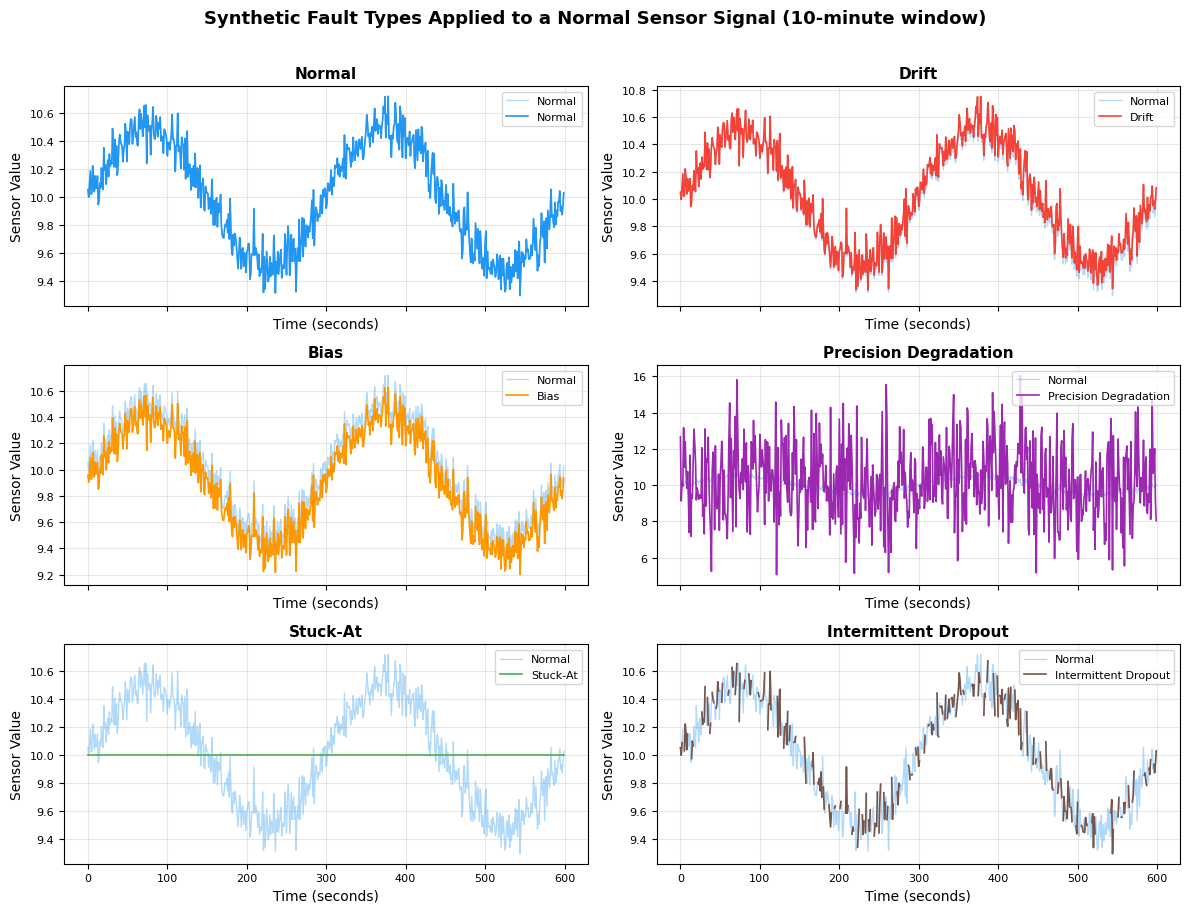

Saved: work/wadi_A1/results/fault_type_visualization.png


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- Synthetic normal signal (10 minutes at 1Hz = 600 rows) ---
np.random.seed(RANDOM_SEED)
n = 600
t = np.arange(n)
normal_signal = pd.Series(
    10.0 + 0.5 * np.sin(2 * np.pi * t / 300) + np.random.normal(0, 0.1, n),
    dtype="float32"
)

# --- Apply each fault type at mid-range parameters ---
faulted = {
    "Normal":                  normal_signal,
    "Drift":                   apply_drift(normal_signal,               rate_pct_per_min=1.5),
    "Bias":                    apply_bias(normal_signal,                offset_pct=25.0),
    "Precision Degradation":   apply_precision_degradation(normal_signal, noise_multiplier=5.0),
    "Stuck-At":                apply_stuck_at(normal_signal,            stuck_pct=0.5),
    "Intermittent Dropout":    apply_intermittent_dropout(normal_signal, dropout_rate=0.4),
}

# --- Plot ---
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True)
axes = axes.flatten()

colors = {
    "Normal":                "#2196F3",
    "Drift":                 "#F44336",
    "Bias":                  "#FF9800",
    "Precision Degradation": "#9C27B0",
    "Stuck-At":              "#4CAF50",
    "Intermittent Dropout":  "#795548",
}

for ax, (name, signal) in zip(axes, faulted.items()):
    ax.plot(t, normal_signal, color="#2196F3", alpha=0.35, linewidth=1.0, label="Normal")
    ax.plot(t, signal,        color=colors[name], linewidth=1.2, label=name)
    ax.set_title(name, fontsize=11, fontweight="bold")
    ax.set_ylabel("Sensor Value")
    ax.legend(fontsize=8, loc="upper right")
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)

for ax in axes:
    ax.set_xlabel("Time (seconds)")

fig.suptitle(
    "Synthetic Fault Types Applied to a Normal Sensor Signal (10-minute window)",
    fontsize=13, fontweight="bold", y=1.01
)
plt.tight_layout()

viz_path = PROJECT_DIR / "results"/ "fault_type_visualization.png"
plt.savefig(viz_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {viz_path}")

# This continues in WaDi Pipeline Notebook 3 - Curate/Validate